In [168]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
from lib import DihedralAdherencePDB
import os
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns

PDBMINE_URL = os.getenv("GREEN_PDBMINE_URL")
PROJECT_DIR_OTHER = 'ml_data'

from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import json
from matplotlib.patches import ConnectionPatch
from sklearn.cluster import KMeans, DBSCAN, MeanShift, HDBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from collections import defaultdict
from tqdm import tqdm
from scipy.linalg import inv
from lib import MultiWindowQuery

PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'casp_da'

pdb_codes = [f.name.split('_')[0] for f in Path(PROJECT_DIR_OTHER).iterdir() if f.is_dir()]

In [3]:
da = DihedralAdherencePDB(
    pdb_codes[0], [4,5,6,7], PDBMINE_URL, PROJECT_DIR_OTHER, mode='full_window',
    kdews=[0, 1, 0, 0]
)
da.load_results()

Results already exist
Structure exists: 'pdb/pdb2rj7.ent' 
UniProt ID: P16442


True

# Validation

In [10]:
pdb_codes2 = [f.name.split('_')[0] for f in Path(PROJECT_DIR_OTHER).iterdir() if f.is_dir()]

In [ ]:
from lib.modules import query_and_process_pdbmine
results = []
results_window = []
lens = []
np.random.seed(42)
choices = np.random.choice(pdb_codes2, 5, replace=False)
for pdb_code in choices:
    da = MultiWindowQuery(pdb_code, [4,5,6,7], PDBMINE_URL, PROJECT_DIR_OTHER)
    idx = np.random.randint(1, len(da.queries))
    r, rw = query_and_process_pdbmine(da.queries[idx])
    results_window.append(rw)
    lens.append(len(da.sequence))

Results already exist
Structure exists: 'pdb/pdb4jse.ent' 
UniProt ID: P29476
Results already exist
Structure exists: 'pdb/pdb7kvk.ent' 
UniProt ID: P08684
Results already exist
Structure exists: 'pdb/pdb4f0z.ent' 
UniProt ID: Q08209
Results already exist
Structure exists: 'pdb/pdb3ihu.ent' 
UniProt ID: Q46SA5
Results already exist
Structure exists: 'pdb/pdb7jhk.ent' 
UniProt ID: Q9NY97


In [39]:
print(np.mean(lens), np.std(lens))
results_window = pd.concat(results_window)
print(results_window.shape)
results_window.to_csv('3mil_angles.csv', index=False)

374.6 87.40160181598505
(2973391, 8)


In [170]:
results_window = pd.read_csv('3mil_angles.csv')

In [171]:
results_window_g = results_window[maskg := (results_window.res == 'G')]
results_window_p = results_window[maskp := (results_window.res == 'P')]
results_window_all = results_window[~maskg & ~maskp]
results_window_g.shape, results_window_p.shape, results_window_all.shape

((174251, 8), (150246, 8), (2648894, 8))

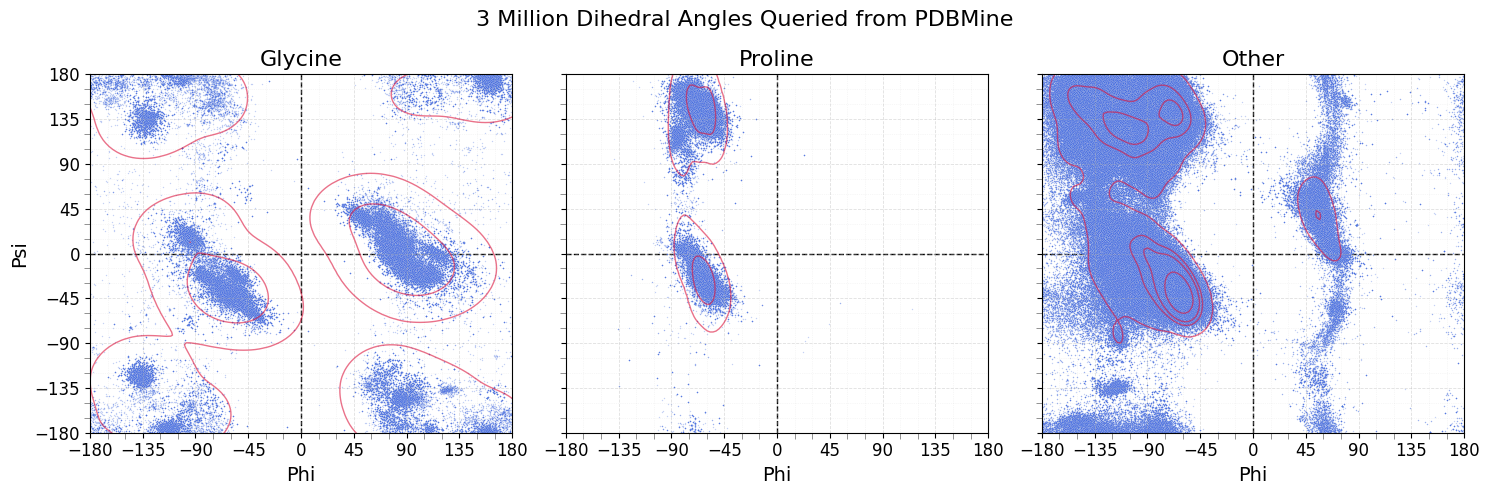

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15,5), sharey=True)
for i,(df,ax) in enumerate(zip([results_window_g, results_window_p, results_window_all], axes)):
    # Scatter plot with better contrast and transparency
    sns.scatterplot(
        data=df,#.sample(1_000_000), 
        x='phi', y='psi', 
        s=1, ax=ax, 
        alpha=0.3, color='royalblue'
    )
    levels = 5 if i == 2 else 3
    sns.kdeplot(
        data=df.sample(len(df)//10),
        x='phi', y='psi', 
        levels=levels, color='crimson', 
        linewidths=1, alpha=0.6, ax=ax
    )

    # Set axis limits and labels
    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)
    ax.set_xlabel('Phi', fontsize=14)
    ax.set_ylabel('Psi', fontsize=14)

    # Improve tick styling
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-180, 181, 45))
    ax.set_xticks(np.arange(-180, 181, 15), minor=True)
    ax.set_yticks(np.arange(-180, 181, 15), minor=True)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', length=4, color='gray')

    # Improve grid styling
    ax.grid(True, linestyle="--", alpha=0.4, linewidth=0.6)
    ax.grid(True, which="minor", linestyle=":", alpha=0.2, linewidth=0.5)

    # Add reference lines
    ax.axhline(0, color='black', linewidth=1, linestyle='--', zorder=0)
    ax.axvline(0, color='black', linewidth=1, linestyle='--', zorder=0)

axes[0].set_title('Glycine', fontsize=16)
axes[1].set_title('Proline', fontsize=16)
axes[2].set_title('Other', fontsize=16)
plt.suptitle('3 Million Dihedral Angles Queried from PDBMine', fontsize=16)
plt.tight_layout()
# plt.show()
plt.savefig('paper_plots/3mil_angles.png', dpi=300)

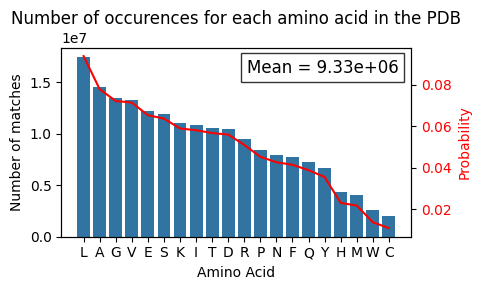

In [178]:
k=1
df = pd.read_csv(f'MegaQuery/win{k}.csv', keep_default_na=False)
df = df.sort_values('n_matches', ascending=False)
df['prob'] = df['n_matches'] / sum(df['n_matches'])

fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(data=df, x='seq', y='n_matches', ax=ax)
ax.set_ylabel('Number of matches')
ax.set_xlabel('Amino Acid')
ax.set_title(f'Number of occurences for each amino acid in the PDB')
ax2 = ax.twinx()
sns.lineplot(data=df, x='seq', y='prob', ax=ax2, color='r')
ax2.set_ylabel('Probability', color='r')
ax2.tick_params(axis='y', labelcolor='r')

ax.text(0.53, 0.94, f'Mean = {df.n_matches.mean():.2e}',transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.8))
# plt.show()

plt.tight_layout()
plt.savefig('paper_plots/mq_win1.png', dpi=300)


In [13]:
amino_acid_probs = {
    'A': 0.0777, 'C': 0.0157, 'D': 0.0530, 'E': 0.0656, 'F': 0.0405,
    'G': 0.0691, 'H': 0.0227, 'I': 0.0591, 'K': 0.0595, 'L': 0.0960,
    'M': 0.0238, 'N': 0.0427, 'P': 0.0469, 'Q': 0.0393, 'R': 0.0526,
    'S': 0.0694, 'T': 0.0550, 'V': 0.0667, 'W': 0.0118, 'Y': 0.0311
}
df2 = pd.DataFrame(amino_acid_probs.items(), columns=['seq', 'prob'])

In [24]:
amino_acid_values = {
    'ALA': 8.3, 'ARG': 5.1, 'ASN': 4.3, 'ASP': 6.0, 'CYS': 1.4,
    'GLN': 3.7, 'GLU': 6.4, 'GLY': 7.3, 'HIS': 2.5, 'ILE': 5.5,
    'LEU': 9.2, 'LYS': 5.4, 'MET': 2.1, 'PHE': 4.2, 'PRO': 4.8,
    'SER': 6.1, 'THR': 5.6, 'TRP': 1.5, 'TYR': 3.6, 'VAL': 7.0
}
df3 = pd.DataFrame(amino_acid_values.items(), columns=['seq', 'prob'])
df3['seq'] = [AMINO_ACID_CODES[seq] for seq in df3['seq']]
df3['prob'] = df3['prob'] / 100

<Axes: xlabel='seq'>

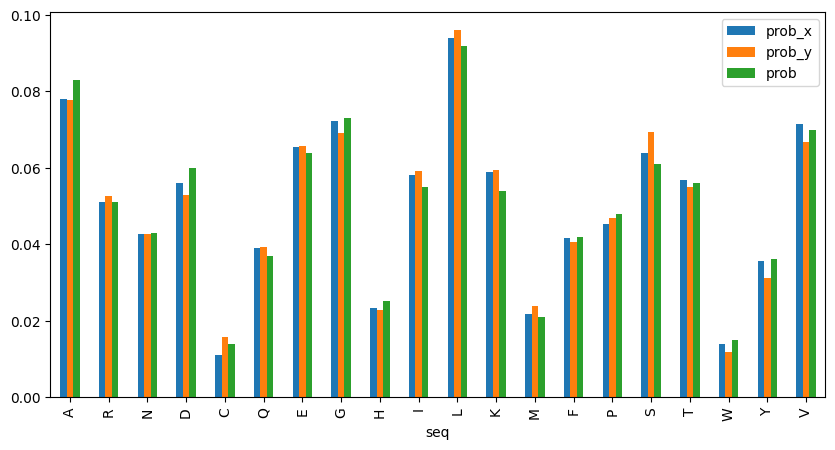

In [27]:
df.merge(df2, on='seq').merge(df3, on='seq').plot(x='seq', y=['prob_x', 'prob_y', 'prob'], kind='bar', figsize=(10,5))

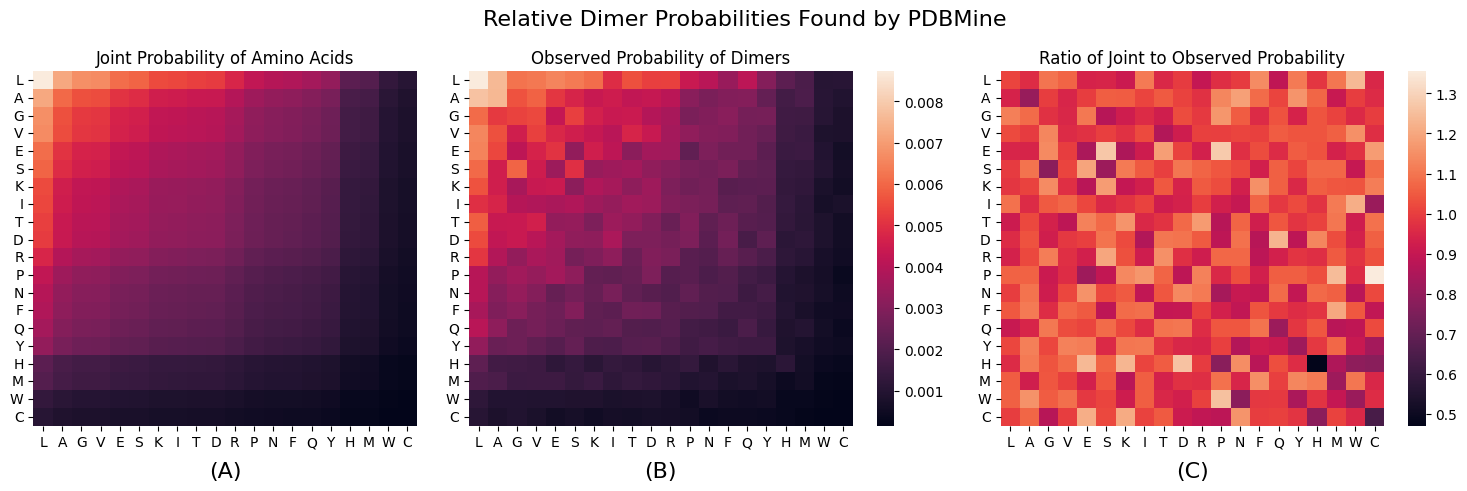

In [179]:
import matplotlib.colors as mcolors

df1 = pd.read_csv('MegaQuery/win1.csv', keep_default_na=False)
df2 = pd.read_csv('MegaQuery/win2.csv' , keep_default_na=False)
df1['prob'] = df1['n_matches'] / sum(df1['n_matches'])
df1 = df1.sort_values('n_matches', ascending=False)
df2['prob'] = df2['n_matches'] / sum(df2['n_matches'])

fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [0.8, 1, 1]})

joint_probs = np.outer(df1.prob, df1.prob)

probs = []
matches = []
seqs = df1.seq
for aa1 in seqs:
    p = []
    m = []
    for aa2 in seqs:
        p.append(df2.loc[df2.seq == aa1+aa2].prob.values[0])
        m.append(df2.loc[df2.seq == aa1+aa2].n_matches.values[0])
    probs.append(p)
    matches.append(m)
probs = np.array(probs)
matches = np.array(matches)

probs_ratio = joint_probs / probs

sns.heatmap(joint_probs, ax=axes[0], cbar=False)
axes[0].set_title('Joint Probability of Amino Acids')
axes[0].set_xticks(np.arange(len(df1.seq))+0.5)
axes[0].set_xticklabels(df1.seq, rotation=0)
axes[0].set_yticks(np.arange(len(df1.seq))+0.5)
axes[0].set_yticklabels(df1.seq, rotation=0)
axes[0].text(0.5, -0.1, '(A)', transform=axes[0].transAxes, fontsize=16, verticalalignment='top', horizontalalignment='center')

sns.heatmap(probs, ax=axes[1])
axes[1].set_title('Observed Probability of Dimers')
axes[1].set_xticks(np.arange(len(df1.seq))+0.5)
axes[1].set_xticklabels(seqs, rotation=0)
axes[1].set_yticks(np.arange(len(df1.seq))+0.5)
axes[1].set_yticklabels(df1.seq, rotation=0)
axes[1].text(0.5, -0.1, '(B)', transform=axes[1].transAxes, fontsize=16, verticalalignment='top', horizontalalignment='center')

sns.heatmap(probs_ratio, ax=axes[2])
axes[2].set_title('Ratio of Joint to Observed Probability')
axes[2].set_xticks(np.arange(len(df1.seq))+0.5)
axes[2].set_xticklabels(seqs, rotation=0)
axes[2].set_yticks(np.arange(len(df1.seq))+0.5)
axes[2].set_yticklabels(df1.seq, rotation=0)
axes[2].text(0.5, -0.1, '(C)', transform=axes[2].transAxes, fontsize=16, verticalalignment='top', horizontalalignment='center')

plt.suptitle('Relative Dimer Probabilities Found by PDBMine', fontsize=16)
plt.tight_layout()
# plt.show()
plt.savefig('paper_plots/dimer_probs.png', dpi=300)

/home/musa/protein-dihedral-visualization/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/musa/protein-dihedral-visualization/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


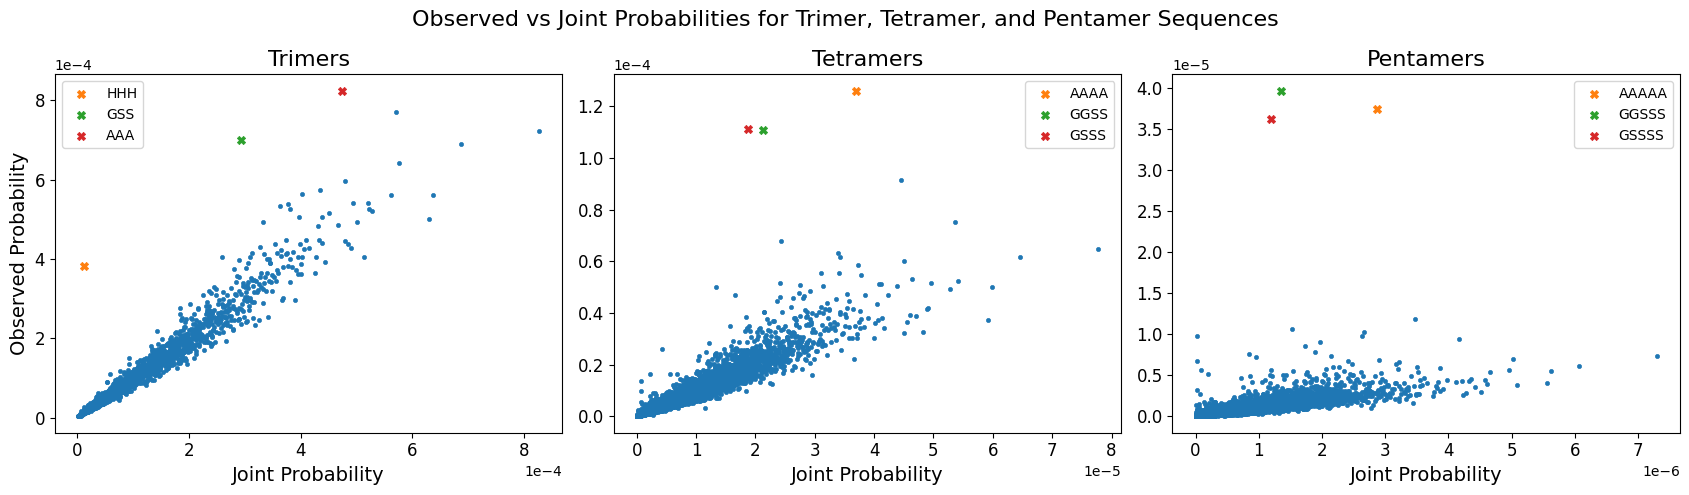

In [183]:
df1 = pd.read_csv('MegaQuery/win1.csv', keep_default_na=False)
df1['prob'] = df1['n_matches'] / sum(df1['n_matches'])
df1 = df1.sort_values('n_matches', ascending=False)

labels = ['Trimers', 'Tetramers', 'Pentamers']
winsizes = [3,4,5]

fig, axes = plt.subplots(1, 3, figsize=(17, 5))
for i in range(3):
    ax = axes[i]
    w = winsizes[i]
    df2 = pd.read_csv(f'MegaQuery/win{w}.csv' , keep_default_na=False)    
    df2['prob'] = df2['n_matches'] / sum(df2['n_matches'])

    log_probs = np.log10(df1.set_index('seq').prob)
    df2['log_prob'] = np.log10(df2.prob)
    df2['log_joint_prob'] = df2.seq.apply(lambda x: np.sum([log_probs[aa] for aa in x]))
    df2['log_probs_ratio'] = df2.log_joint_prob - df2.log_prob
    df2['probs_ratio'] = 10**df2.log_probs_ratio
    df2['joint_prob'] = 10**df2.log_joint_prob

    df2['seq_key'] = df2.seq.apply(lambda x: ''.join(sorted(x)))
    df2 = df2.groupby('seq_key').mean(numeric_only=True).reset_index().rename(columns={'seq_key': 'seq'})

    sns.scatterplot(data=df2[(df2.seq != 'HHHH') & (df2.seq != 'HHHHH')], x='joint_prob', y='prob', marker='.', ax=ax, edgecolor=None)
    # sns.scatterplot(data=df2, x='joint_prob', y='prob', marker='.', ax=ax, edgecolor=None)

    if i == 0:
        sns.scatterplot(data=df2[df2.seq=='HHH'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='HHH')
        sns.scatterplot(data=df2[df2.seq=='GSS'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='GSS')
        sns.scatterplot(data=df2[df2.seq=='AAA'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='AAA')
        ax.set_ylabel('Observed Probability', fontsize=14)
        ax.legend(loc='upper left')
    elif i == 1:
        # print(f'Tetramer: {df2.loc[df2.seq == "HHHH", ['joint_prob', 'prob']].values}')
        sns.scatterplot(data=df2[df2.seq=='AAAA'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='AAAA')
        sns.scatterplot(data=df2[df2.seq=='GGSS'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='GGSS')
        sns.scatterplot(data=df2[df2.seq=='GSSS'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='GSSS')
        ax.set_ylabel('')
        ax.legend()

    elif i == 2:
        # print(f'Pentamer: {df2.loc[df2.seq == "HHHHH", ['joint_prob', 'prob']].values}')
        sns.scatterplot(data=df2[df2.seq=='AAAAA'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='AAAAA')
        sns.scatterplot(data=df2[df2.seq=='GGSSS'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='GGSSS')
        sns.scatterplot(data=df2[df2.seq=='GSSSS'], x='joint_prob', y='prob', marker='X', ax=ax, edgecolor=None, label='GSSSS')
        ax.set_ylabel('')
        ax.legend()

    ax.set_title(labels[i], fontsize=16)
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel('Joint Probability', fontsize=14)

plt.suptitle('Observed vs Joint Probabilities for Trimer, Tetramer, and Pentamer Sequences', fontsize=16)
plt.tight_layout()
# plt.show()
plt.savefig('paper_plots/joint_probs.png', dpi=300)

In [ ]:
pd.DataFrame(list(''.join(df[df.n_matches == 0].seq.values.tolist()))).groupby(0).size().sort_values(ascending=False)

Initializing T1030 ...
casp_da/T1030_win4-5-6-7
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 


UniProt ID: Q8DWZ6


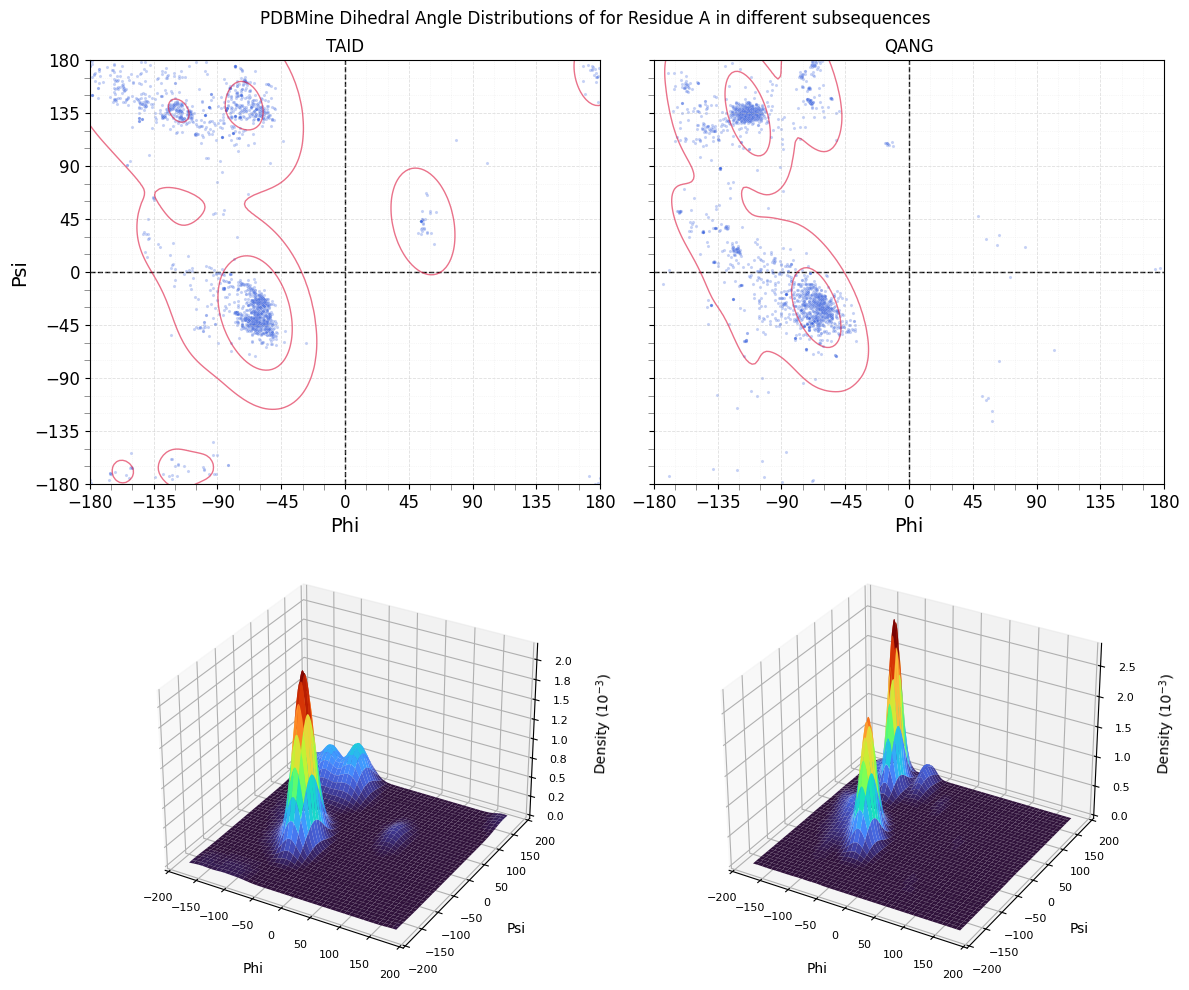

In [184]:
da = DihedralAdherence('T1030', [4,5,6,7], PDBMINE_URL, PROJECT_DIR, mode='full_window')
da.load_results()
from lib.utils import get_phi_psi_dist
from scipy.stats import gaussian_kde
from matplotlib.ticker import FuncFormatter
fig, axes = plt.subplots(2,2, figsize=(12,10), sharey=True)
for i, seq in enumerate(['YNTAIDN', 'VNQANGK']):
    phi_psi_dist,_ = get_phi_psi_dist([da.queries[0]], seq)
    seq = da.queries[0].get_subseq(seq)
    ax = axes[0, i]
    sns.scatterplot(
        data=phi_psi_dist,
        x='phi', y='psi', 
        s=5, ax=ax, 
        alpha=0.3, color='royalblue'
    )
    sns.kdeplot(
        data=phi_psi_dist,
        x='phi', y='psi', 
        levels=3, color='crimson', 
        linewidths=1, alpha=0.6, ax=ax
    )

    # Set axis limits and labels
    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)
    ax.set_xlabel('Phi', fontsize=14)
    ax.set_ylabel('Psi', fontsize=14)

    # Improve tick styling
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-180, 181, 45))
    ax.set_xticks(np.arange(-180, 181, 15), minor=True)
    ax.set_yticks(np.arange(-180, 181, 15), minor=True)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='minor', length=4, color='gray')

    # Improve grid styling
    ax.grid(True, linestyle="--", alpha=0.4, linewidth=0.6)
    ax.grid(True, which="minor", linestyle=":", alpha=0.2, linewidth=0.5)

    # Add reference lines
    ax.axhline(0, color='black', linewidth=1, linestyle='--', zorder=0)
    ax.axvline(0, color='black', linewidth=1, linestyle='--', zorder=0)

    ax.set_title(seq)


    x = phi_psi_dist[['phi','psi']].values.T
    weights = phi_psi_dist['weight'].values
    kde = gaussian_kde(x, weights=weights)

    x_grid, y_grid = np.meshgrid(np.linspace(-180, 180, 360), np.linspace(-180, 180, 360))
    grid = np.vstack([x_grid.ravel(), y_grid.ravel()])
    z = kde(grid).reshape(x_grid.shape)
    # print(f'Max: P({grid[0,z.argmax()]:02f}, {grid[1,z.argmax()]:02f})={z.max():02f}')

    cm = plt.get_cmap('turbo')

    axes[1, i].remove()
    axes[1, i] = fig.add_subplot(2, 2, i+3, projection='3d')
    ax = axes[1, i]
    surf = ax.plot_surface(x_grid, y_grid, z, cmap=cm)

    ax.zaxis.set_major_formatter(FuncFormatter(lambda x,pos:f'{x * 10e3:.1f}'))
    ax.set_xlabel('Phi', fontsize=10, labelpad=10)
    ax.set_ylabel('Psi', fontsize=10, labelpad=10)
    ax.set_zlabel(r'Density $(10^{-3})$', fontsize=10, labelpad=10)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    ax.zaxis.set_tick_params(labelsize=8)
    ax.set_box_aspect(aspect=None, zoom=1)
    ax.set_adjustable('box')
plt.suptitle('PDBMine Dihedral Angle Distributions of for Residue A in different subsequences')
plt.tight_layout()
# plt.show()
plt.savefig('paper_plots/2_dihedral_dist.png', dpi=300)

In [185]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_ramachandran(ax, z=0, alpha=0.6):
    # Define the shapes with given coordinates
    shapes = [
        (1, [(-156.5, 91.3), (-70.4, 91.3), (-54.7, 112.8), (-54.7, 173.2), (-136.9, 173.2), (-136.9, 155.8), (-156.5, 135.6), (-156.5, 91.3)]),
        (0, [(-180.0, 42.9), (-140.8, 16.1), (-86.0, 16.1), (-74.3, 45.6), (-74.3, 72.5), (-44.3, 102.0), (-44.3, 161.1), (-46.9, 179.9), (-180.0, 180.0)]),
        (0, [(-180.0, -34.9), (-164.3, -42.9), (-133.0, -42.9), (-109.4, -32.2), (-106.9, -21.4), (-44.3, -21.4), (-44.3, -71.1), (-180.0, -71.1)]),
        (1, [(-156.5, -60.4), (-54.7, -60.4), (-54.7, -40.2), (-100.4, -40.2), (-123.9, -51.0), (-156.5, -51.0), (-156.5, -60.4)]),
        (0, [(-180.0, -180.0), (-180.0, -163.8), (-75.6, -163.8), (-46.9, -180.0)]),
        (0, [(62.6, 14.7), (62.6, 96.7), (45.6, 79.2), (45.6, 26.8), (62.6, 14.7)])
    ]

    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)
    ax.set_xlabel("psi")
    ax.set_ylabel("phi")
    ax.grid(True, linestyle='--', linewidth=0.5)

    # Plot each shape
    for type, shape in shapes:
        if type == 0:
            polygon = patches.Polygon(shape, closed=True, edgecolor='black', facecolor='yellow', alpha=alpha, zorder=z-1)
        else:
            polygon = patches.Polygon(shape, closed=True, edgecolor='black', facecolor='red', alpha=alpha, zorder=z)
        ax.add_patch(polygon)

    ax.set_xticks(range(-180, 181, 60))
    ax.set_yticks(range(-180, 181, 60))

/tmp/ipykernel_2006668/2701654615.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


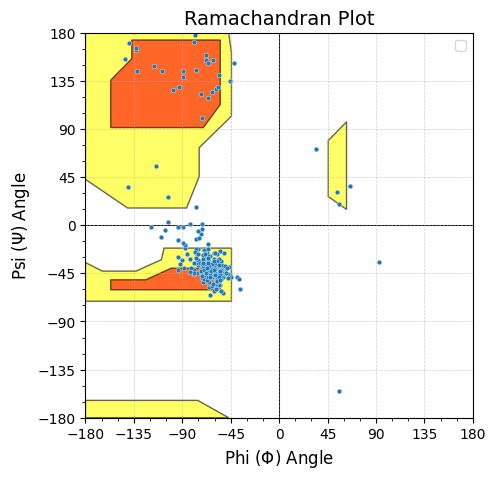

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(5, 5))

sns.scatterplot(data=da.xray_phi_psi, x='phi', y='psi', ax=ax, alpha=1, s=12)

plot_ramachandran(ax)

ax.set_title("Ramachandran Plot", fontsize=14)
ax.set_xlabel(r"Phi ($\Phi$) Angle", fontsize=12)
ax.set_ylabel(r"Psi ($\Psi$) Angle", fontsize=12)

ax.set_xlim(-180, 180)
ax.set_ylim(-180, 180)

ax.set_xticks(np.arange(-180, 181, 15), minor=True)
ax.set_yticks(np.arange(-180, 181, 15), minor=True)
ax.grid(True, linestyle="--", alpha=0.6)
ax.set_xticks(np.arange(-180, 181, 45))
ax.set_yticks(np.arange(-180, 181, 45))

ax.axhline(0, color='black', linewidth=0.75, zorder=0)
ax.axvline(0, color='black', linewidth=0.75, zorder=0)
ax.legend()

plt.show()

In [ ]:
from lib.utils import get_phi_psi_dist

da = DihedralAdherencePDB('2RJ7', [4,5,6,7], PDBMINE_URL, PROJECT_DIR_OTHER, mode='full_window', kdews=[0,1,0,0])
phi_psi_dist, results = get_phi_psi_dist(da.queries, da.seqs[10])
xrays = da.xray_phi_psi.loc[da.xray_phi_psi['seq_ctxt'] == da.seqs[10], ['phi', 'psi']]

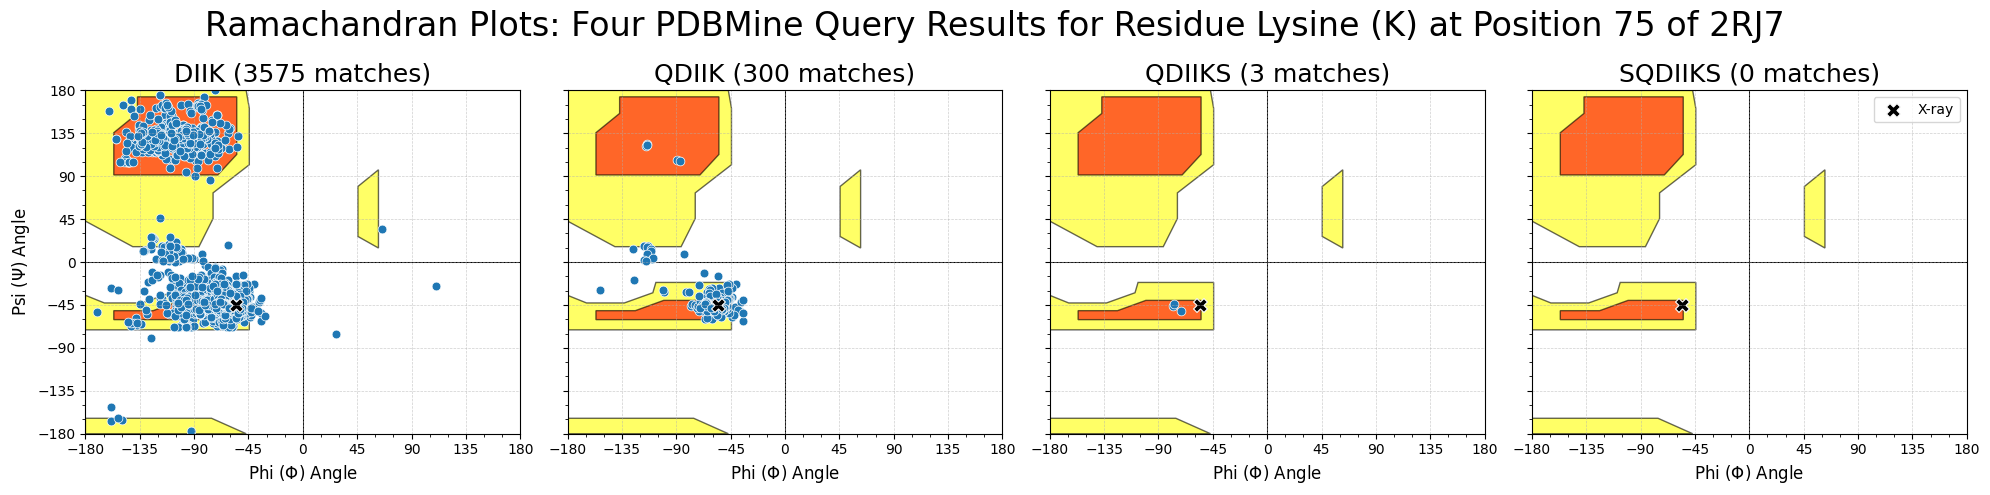

In [188]:
fig, axes = plt.subplots(1, len(da.winsizes), figsize=(20, 5), sharey=True)
for i,(w,ax) in enumerate(zip(da.winsizes, axes)):
    df = phi_psi_dist[phi_psi_dist['winsize'] == w]
    sns.scatterplot(data=df, x='phi', y='psi', ax=ax, alpha=1, s=40, label='PDBMine Results')
    sns.scatterplot(data=xrays, x='phi', y='psi', ax=ax, alpha=1, marker='X', s=100, color='black', label='X-ray')

    plot_ramachandran(ax)


    ax.set_title(f"{results[i][1]} ({results[i][2]} matches)", fontsize=18)
    if w == da.winsizes[0]:
        ax.set_ylabel(r"Psi ($\Psi$) Angle", fontsize=12)

    ax.set_xlabel(r"Phi ($\Phi$) Angle", fontsize=12)

    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)

    ax.set_xticks(np.arange(-180, 181, 15), minor=True)
    ax.set_yticks(np.arange(-180, 181, 15), minor=True)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-180, 181, 45))
    ax.axhline(0, color='black', linewidth=0.75, zorder=0)
    ax.axvline(0, color='black', linewidth=0.75, zorder=0)

    if w == da.winsizes[-1]:
        ax.legend()
    else:
        ax.get_legend().remove()

plt.suptitle(f"Ramachandran Plots: Four PDBMine Query Results for Residue Lysine (K) at Position 75 of 2RJ7", fontsize=24)
plt.tight_layout()
# plt.show()
plt.savefig('paper_plots/4_ramachandran.png', dpi=300)

In [156]:
proteins = [
  'T1024', 'T1030', 'T1030-D2', 'T1024-D1', 'T1032-D1', 'T1053-D1', 'T1027-D1', 'T1029-D1',
  'T1025-D1', 'T1028-D1', 'T1030-D1', 'T1053-D2', 'T1057-D1','T1058-D1', 'T1058-D2'
]


In [55]:
da = DihedralAdherence('T1058-D1', [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[0,1,0,0], mode='full_window')
# da.load_results_da()
# da.queries = da.queries[1:]
# da.winsizes = da.winsizes[1:]
# center_idx_ctxt = da.queries[-1].get_center_idx_pos()
# winsize_ctxt = da.queries[-1].winsize
# seqs_for_window = da.seqs[center_idx_ctxt:-(winsize_ctxt - center_idx_ctxt - 1)]

# da.plot_across_window_clusters(seqs_for_window[1], plot_xrays=False, plot_afs=False, n_cluster_lines=25)
# T1053-D1
# da.plot_across_window_cluster_medoids(seqs_for_window[15], verbose=True, mode_scatter=True, plot_xrays=True)
# da.plot_across_window_cluster_medoids('FAAALKI', verbose=True, mode_scatter=True, plot_xrays=True)
# da.plot_across_window_cluster_medoids('HYPELLA', verbose=True, mode_scatter=True, plot_xrays=True)

# T1030
# da.plot_across_window_cluster_medoids('KLENLSN', verbose=True, mode_scatter=True, plot_xrays=True)
# da.plot_across_window_cluster_medoids('LVKSISS', verbose=True, mode_scatter=True, plot_xrays=True)
# da.plot_across_window_cluster_medoids('SKDSQLI', verbose=True, mode_scatter=True, plot_xrays=True)
# da.plot_across_window_cluster_medoids('KQTFGNR', verbose=True, mode_scatter=True, plot_xrays=True)

Initializing T1058-D1 ...
casp_da/T1058-D1_win4-5-6-7
Results already exist
Casp ID: T1058-D1 	PDB: 7abw
Desired structure doesn't exist


FileNotFoundError: [Errno 2] No such file or directory: 'pdb/pdb7abw.ent'

Results already exist
Structure exists: 'pdb/pdb7eik.ent' 
UniProt ID: O60885
	Win 5: NKPGD - 753 samples
	Win 6: NKPGDD - 666 samples
	Win 7: YNKPGDD - 660 samples
Number of clusters: 4
(710, 10)
Cluster 0 has 67 members and medoid [ -87.3 -130.   -70.    88.3  -60.3   -2.8   75.1  159.    16.9  147.9]
Cluster 1 has 60 members and medoid [-91.4 -80.5 -56.4 -81.9 -71.5 162.9 144.2 -29.   -4.3 143.4]
Cluster 2 has 563 members and medoid [-104.  -106.1  -53.9   84.7  -61.8  178.5  150.2  138.3  -11.3  148.8]
Cluster 3 has 20 members and medoid [-93.1 -58.1 -47.9 122.1 -84.4 118.3 136.  110.   -0.4 146.9]


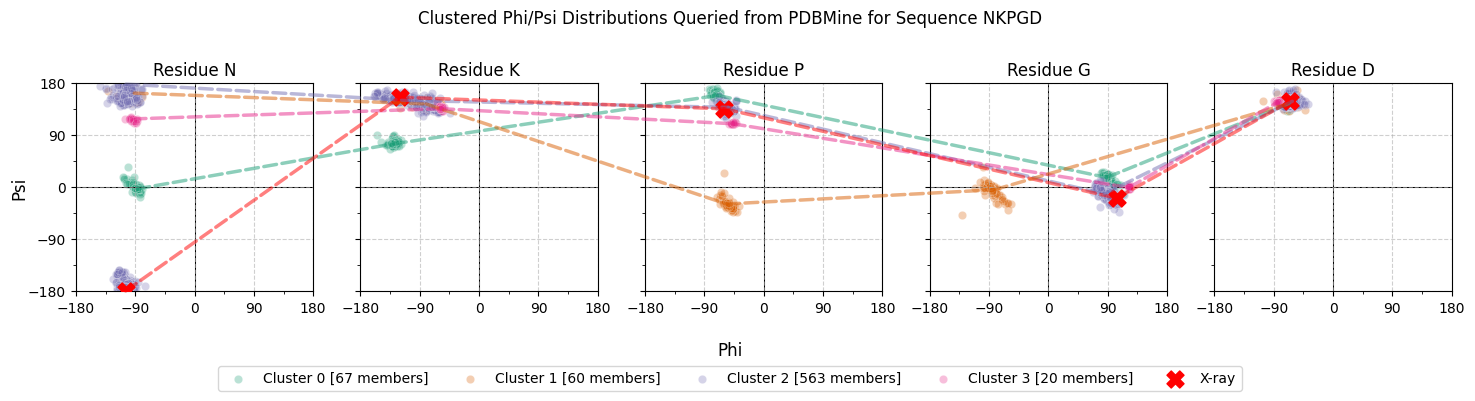

In [80]:
da = DihedralAdherencePDB('7EIK', [4,5,6,7], PDBMINE_URL, PROJECT_DIR_OTHER, mode='full_window', kdews=[0,1,0,0])
da.load_results()
da.queries = da.queries[1:]
da.winsizes = da.winsizes[1:]
da.plot_across_window_cluster_medoids('YNKPGDD', verbose=True, mode_scatter=True, plot_xrays=True, cse=30)


In [46]:
da = DihedralAdherence(proteins[1], [4,5,6,7], PDBMINE_URL, PROJECT_DIR, kdews=[0,1,0,0], mode='full_window')
da.load_results()

Initializing T1030 ...
casp_da/T1030_win4-5-6-7
Results already exist
Casp ID: T1030 	PDB: 6poo
Structure exists: 'pdb/pdb6poo.ent' 
UniProt ID: Q8DWZ6


In [ ]:
ins = da
from lib.across_window_utils import get_afs_window, get_xrays_window, get_preds_window, get_combined_phi_psi_dist, precompute_dists, find_clusters, filter_precomputed_dists
MIN_SAMPLES = [100, 20, 1, 1]
MIN_CLUSTER_SIZES = [20, 5, 1, 1]

center_idx_ctxt = ins.queries[-1].get_center_idx_pos()
winsize_ctxt = ins.queries[-1].winsize
seqs_for_window = ins.seqs[center_idx_ctxt:-(winsize_ctxt - center_idx_ctxt - 1)]

n_cluster_results = []
for i,seq_ctxt in enumerate(seqs_for_window):
    print(f'{i}/{len(ins.xray_phi_psi.seq_ctxt.unique())-1}: {seq_ctxt}')
    if 'X' in seq_ctxt:
        print(f'\tSkipping {seq_ctxt} - X in sequence')
        continue

    _, info = get_phi_psi_dist(ins.queries, seq_ctxt)
    for j in info:
        print(f'\tWin {j[0]}: {j[1]} - {j[2]} samples')

    # TODO n_samples

    q = ins.queries[0]
    # xrays = get_xrays_window(ins, q, seq_ctxt)
    # preds = get_preds_window(ins, q, seq_ctxt)
    # afs = get_afs_window(ins, q, seq_ctxt)

    # if xrays.shape[0] != q.winsize*2:
        # print(f"Xray data for {seq_ctxt} is incomplete")
        # continue
    
    phi_psi_dist, phi_psi_dist_v = get_combined_phi_psi_dist(ins, seq_ctxt)
    if phi_psi_dist is None or phi_psi_dist.shape[0] == 0:
        print(f"No pdbmine data for {seq_ctxt}")
        continue
    if phi_psi_dist.shape[0] < MIN_SAMPLES[0]:
        print(f"Not enough pdbmine data for {seq_ctxt}")
        continue

    precomputed_dists = precompute_dists(phi_psi_dist_v)
    n_clusters, clusters = find_clusters(precomputed_dists, MIN_CLUSTER_SIZES[0])
    if n_clusters == 0:
        print(f"No clusters found for {seq_ctxt}")
        continue
    n_cluster_results.append((info[0][2], n_clusters))

In [48]:
n_cluster_results = pd.DataFrame(n_cluster_results, columns=['n_samples', 'n_clusters'])

In [45]:
n_cluster_results_4 = n_cluster_results

# 500 samples

In [4]:
pdb_codes_2 = [d.name.split('_')[0] for d in Path(PROJECT_DIR_OTHER).iterdir()]

In [93]:
win7_proteins = pd.read_csv('win7-clusters-1000.csv')['protein'].unique()
# win7_proteins = pd.read_csv('win6-clusters-1000.csv')['protein'].unique()
pdb_codes_2 = np.setdiff1d(np.array(pdb_codes_2), win7_proteins)

In [28]:
seqs_per_protein = 8
samples = np.random.choice(pdb_codes_2, 600 // seqs_per_protein, replace=False)

In [5]:
from lib.across_window_utils import get_combined_phi_psi_dist, precompute_dists, find_clusters, filter_precomputed_dists
from lib.utils import get_phi_psi_dist
def get_n_clusters(ins, k):
    MIN_SAMPLES = [100, 20, 5, 5]
    MIN_CLUSTER_SIZES = [20, 5, 1, 1]

    center_idx_ctxt = ins.queries[-1].get_center_idx_pos()
    winsize_ctxt = ins.queries[-1].winsize
    seqs_for_window = ins.seqs[center_idx_ctxt:-(winsize_ctxt - center_idx_ctxt - 1)]

    seq_ctxt = None
    n_skipped = 0
    while seq_ctxt is None:
        if n_skipped > 30:
            print(f"Skipping {da.pdb_code}")
            return None, None, None, None
        n_skipped += 1
        seq_ctxt = np.random.choice(seqs_for_window, 1)[0]
        if 'X' in seq_ctxt:
            print(f'\tSkipping {seq_ctxt} - X in sequence')
            seq_ctxt = None
            continue
        phi_psi_dist, phi_psi_dist_v = get_combined_phi_psi_dist(ins, seq_ctxt)
        if phi_psi_dist is None or phi_psi_dist.shape[0] == 0:
            print(f"No pdbmine data for {seq_ctxt}")
            seq_ctxt = None
            continue
        if phi_psi_dist.shape[0] < MIN_SAMPLES[k]:
            print(f"Not enough pdbmine data for {seq_ctxt} ({phi_psi_dist.shape[0]})")
            seq_ctxt = None
            continue
    if phi_psi_dist.shape[0] > 2500:
        phi_psi_dist = phi_psi_dist.sample(2500)
    _, info = get_phi_psi_dist(ins.queries, seq_ctxt)
    print(f'\tWin {info[k][0]}: {info[k][1]} - {info[k][2]} samples')
    precomputed_dists = precompute_dists(phi_psi_dist_v)
    n_clusters, clusters = find_clusters(precomputed_dists, MIN_CLUSTER_SIZES[0])
    return da.pdb_code, seq_ctxt, info[k][2], n_clusters

In [34]:
da.has_af

False

In [35]:
results = []
n_skipped = 0
k=3
kdews = [0, 0, 0, 0]
kdews[k] = 1
# for i,sample in enumerate(samples):
for i,sample in enumerate(['7YYX']):
    print(f'{i}/{len(samples)-1}: {sample}')
    da = DihedralAdherencePDB(
        sample, [4,5,6,7], PDBMINE_URL, PROJECT_DIR_OTHER, mode='full_window',
        kdews=kdews
    )
    if (not da.has_af or
        len([d for d in da.outdir.iterdir()]) == 0 or 
        not (da.outdir / 'xray_phi_psi.csv').exists()
    ):
        n_skipped += 1
        continue
    if not da.load_results():
        n_skipped += 1
        continue
    if da.xray_phi_psi.shape[0] == 0 or len(da.seqs) <= 6:
        n_skipped += 1
        continue
    for i in range(seqs_per_protein):
        ret = get_n_clusters(da, k)
        if ret[0] is None:
            n_skipped += 1
            break
        results.append(ret)
results = pd.DataFrame(results, columns = ['protein', 'seq_ctxt', 'n_samples', 'n_clusters'])

0/74: 7YYX
Results already exist
Structure exists: 'pdb/pdb7yyx.ent' 


No UniProt mapping found for 7YYX


In [ ]:
least_len = min(
    pd.read_csv('win4-clusters-3000.csv').shape[0],
    pd.read_csv('win5-clusters-3000.csv').shape[0],
    pd.read_csv('win6-clusters-3000.csv').shape[0],
    pd.read_csv('win7-clusters-3000.csv').shape[0]
)

In [191]:
least_len = 2700

In [204]:
results

,protein,seq_ctxt,n_samples,n_clusters
2464,2ZXH,YIKQEEV,1479,6
1256,7N8G,LDTSEVV,1796,12
2263,2Q5F,IHFARFR,1690,14
1990,9PAP,GNSYGVC,2064,21
1507,8XX1,RGDQAFT,606,9
...,...,...,...,...
81,3WNM,SLTNGQS,894,13
1842,7LAU,GTIKRRL,1438,9
2316,8HEJ,YTIAALL,10154,11
649,3IRH,IHVQHQV,330,2


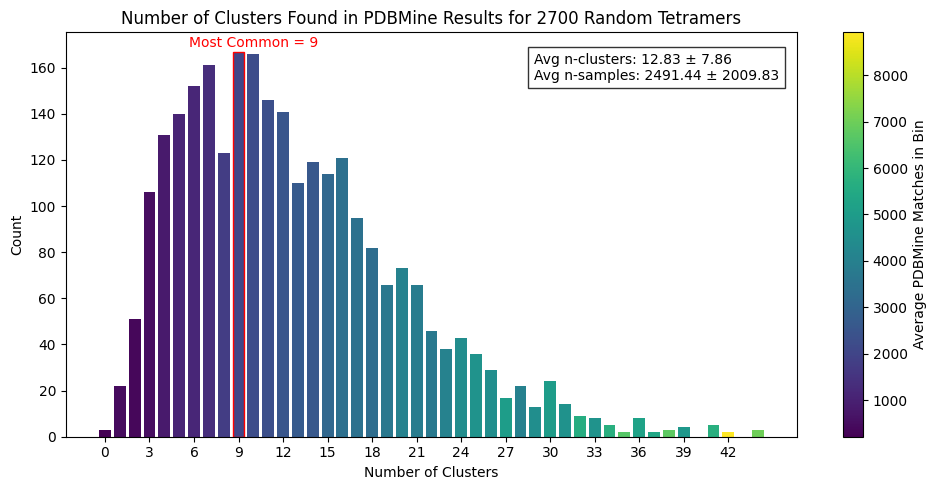

In [208]:
results = pd.read_csv('win4-clusters-3000.csv').sample(least_len)
results = results[results['n_samples'] < results['n_samples'].quantile(0.999)]
grouped = results.groupby('n_clusters').agg({'n_samples': 'mean', 'n_clusters': 'count'}).rename(columns={'n_clusters': 'count'}).reset_index()

grouped = grouped[grouped['count'] > grouped['count'].quantile(0.01)]

norm = plt.Normalize(grouped['n_samples'].min(), grouped['n_samples'].max())
colors = plt.cm.viridis(norm(grouped['n_samples']))

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(grouped['n_clusters'], grouped['count'], color=colors)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Average PDBMine Matches in Bin')

ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Count')
ax.set_title('Number of Clusters Found in PDBMine Results for 2700 Random Tetramers')

ax.set_xticks(np.arange(0, grouped['n_clusters'].max(), 3))

avg_clusters = results['n_clusters'].mean()
std_clusters = results['n_clusters'].std()
avg_samples = results['n_samples'].mean()
std_samples = results['n_samples'].std()

# Add text annotations for averages and standard deviations
text_str = (f'Avg n-clusters: {avg_clusters:.2f} ± {std_clusters:.2f}\n'
            f'Avg n-samples: {avg_samples:.2f} ± {std_samples:.2f}')
ax.text(0.64, 0.95, text_str, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.8))

most_common = grouped.loc[grouped['count'].idxmax(), 'n_clusters']
highlight_index = grouped[grouped['n_clusters'] == most_common].index
if not highlight_index.empty:
    bars[highlight_index[0]].set_edgecolor('red')
    bars[highlight_index[0]].set_linewidth(1)
    ax.text(10, grouped.loc[highlight_index[0], 'count']+0.5, f'Most Common = {most_common}',
            ha='center', va='bottom', color='red', fontsize=10)
    
plt.tight_layout()
# plt.show()
plt.savefig('paper_plots/n_clusters-4.png', dpi=300)

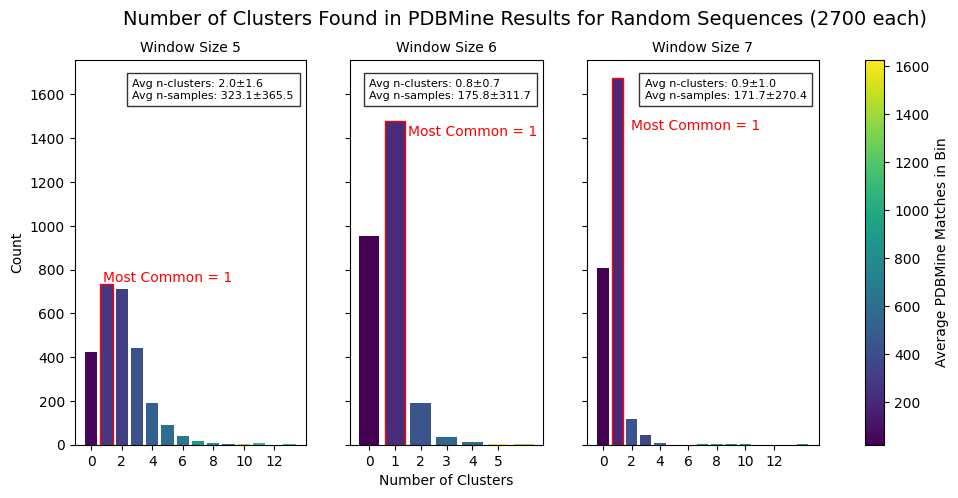

In [234]:
results5 = pd.read_csv('win5-clusters-3000.csv').sample(least_len)
results6 = pd.read_csv('win6-clusters-3000.csv').sample(least_len)
results7 = pd.read_csv('win7-clusters-3000.csv').sample(least_len)

results5 = results5[results5['n_samples'] < results5['n_samples'].quantile(0.99)]
results6 = results6[results6['n_samples'] < results6['n_samples'].quantile(0.99)]
results7 = results7[results7['n_samples'] < results7['n_samples'].quantile(0.99)]

grouped5 = results5.groupby('n_clusters').agg({'n_samples': 'mean', 'n_clusters': 'count'}).rename(columns={'n_clusters': 'count'}).reset_index()
grouped6 = results6.groupby('n_clusters').agg({'n_samples': 'mean', 'n_clusters': 'count'}).rename(columns={'n_clusters': 'count'}).reset_index()
grouped7 = results7.groupby('n_clusters').agg({'n_samples': 'mean', 'n_clusters': 'count'}).rename(columns={'n_clusters': 'count'}).reset_index()
grouped5 = grouped5[grouped5['count'] > grouped5['count'].quantile(0.01)]
grouped6 = grouped6[grouped6['count'] > grouped6['count'].quantile(0.01)]
grouped7 = grouped7[grouped7['count'] > grouped7['count'].quantile(0.01)]

all_samples = pd.concat([grouped5, grouped6, grouped7], axis=0)['n_samples']
norm = plt.Normalize(all_samples.min(), all_samples.max())

fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, gridspec_kw={'width_ratios': [1.2, 1, 1.2]})
text_adj = [(5,0),(4,80),(6.5,250)]
stats_adj = [0.25, 0.1, 0.25]
results = [results5, results6, results7]
for i, (grouped, ax) in enumerate(zip([grouped5, grouped6, grouped7], axes)):
    colors = plt.cm.viridis(norm(grouped['n_samples']))

    bars = ax.bar(grouped['n_clusters'], grouped['count'], color=colors)
        
    ax.set_xticks(np.arange(0, grouped['n_clusters'].max(), (1 if i == 1 else 2)))
    ax.set_title(f'Window Size {i+5}', fontsize=10)
    

    avg_clusters = results[i]['n_clusters'].mean()
    std_clusters = results[i]['n_clusters'].std()
    avg_samples = results[i]['n_samples'].mean()
    std_samples = results[i]['n_samples'].std()

    text_str = (f'Avg n-clusters: {avg_clusters:.1f}±{std_clusters:.1f}\n'
                f'Avg n-samples: {avg_samples:.1f}±{std_samples:.1f}')
    ax.text(stats_adj[i], 0.95, text_str, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0.8))

    most_common = grouped.loc[grouped['count'].idxmax(), 'n_clusters']
    highlight_index = grouped[grouped['n_clusters'] == most_common].index
    if not highlight_index.empty:
        bars[highlight_index[0]].set_edgecolor('red')
        bars[highlight_index[0]].set_linewidth(1)
        ax.text(text_adj[i][0], grouped.loc[highlight_index[0], 'count']-text_adj[i][1], f'Most Common = {most_common}',
                ha='center', va='bottom', color='red', fontsize=10)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=axes, label='Average PDBMine Matches in Bin')
plt.suptitle('Number of Clusters Found in PDBMine Results for Random Sequences (2700 each)', fontsize=14)

axes[1].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Count')

# plt.tight_layout()
# plt.show()
plt.savefig('paper_plots/n_clusters-567.png', dpi=300)